# Installs and Import Data

In [0]:
! pip install torch -q
! pip install torchvision -q
! pip install fastcore -q
! pip install fastai2 -q
! pip install git+https://github.com/thomasbrandon/mish-cuda -q
! git clone https://github.com/pgmmpk/tfrecord.git

In [0]:
!wget 'insert url here' -O 'flowers.zip'

In [0]:
! unzip -q flowers.zip -d flowers

# Imports

In [2]:
%tensorflow_version 1.x
from fastai2.vision.all import *
import tensorflow as tf
from tfrecord.tfrecord import *
from mish_cuda import MishCuda
import gc

TensorFlow 1.x selected.



# Setup Dataloader

In [0]:
path = Path('flowers/tfrecords-jpeg-224x224')

train_fnames = get_files(path/'train', extensions='.tfrec')
test_fnames = get_files(path/'val', extensions='.tfrec')

In [0]:
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

In [0]:
data = []
for name in train_fnames+test_fnames:
  r = Reader(str(name), unpack_sample)
  for sample in r:
    data.append([sample['image'][0], sample['class'][0]])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [0]:
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

splitter = IndexSplitter(range(12753, len(data)))

def get_items(*args, **kwargs): return data

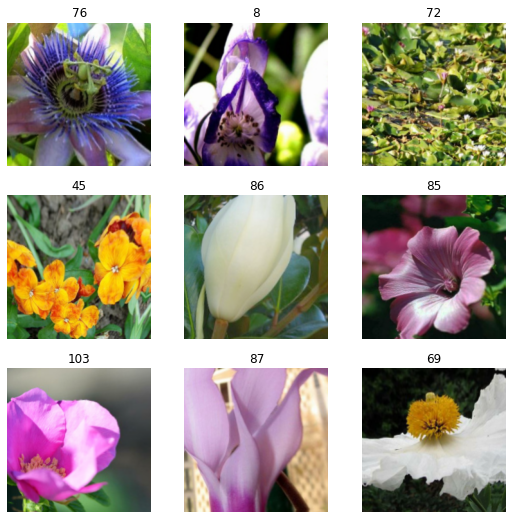

In [0]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[RandomResizedCrop(224, min_scale=0.7)],
                  batch_tfms=[*aug_transforms(do_flip=True)])

dls = block.dataloaders([''], bs=64)

dls.show_batch()

# MK-ResNeXt-50

MK-ResNeXt (Mixed Depthwise Convolutional Kernel or Multi-Kernel RexNeXt) is a modification of fast.ai's X-ResNeXt using mixed depthwise convolutions (MDConv) proposed by [Mingxing Tan & Quoc V. Le](https://arxiv.org/abs/1907.09595/).

This notebook contains two early variants, F & G, modified with Network Deconvolution layers in the stem from [Ye et al](https://openreview.net/forum?id=rkeu30EtvS). MK-ResNeXt-F is a modification of MK-ResNeXt-E except the squeeze and excite layer has been moved back to the standard location in the ResNeXt bottleneck. Without squeeze and excite it is identical to MK-ResNeXt-E with a deconv stem. MK-ResNeXt-G modifies MK-ResNeXt-D by placing squeeze and excite in the standard location, and changes the first layer of the ResNeXt bottleneck to be a deconvolution layer.

Modifying MK-ResNeXt-F with a first layer deconvolution layer resulted in over doubling of epoch time with no improvements, so the runs were not finished and are not reported. 


## Deconvolution
From [Ye et al.](https://openreview.net/forum?id=rkeu30EtvS): https://github.com/yechengxi/deconvolution

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.nn.modules import conv
from torch.nn.modules.utils import _pair


#iteratively solve for inverse sqrt of a matrix
def isqrt_newton_schulz_autograd(A, numIters):
    dim = A.shape[0]
    normA=A.norm()
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z@Y)
        Y = Y@T
        Z = T@Z
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)
    return A_isqrt

def isqrt_newton_schulz_autograd_batch(A, numIters):
    batchSize,dim,_ = A.shape
    normA=A.view(batchSize, -1).norm(2, 1).view(batchSize, 1, 1)
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device).unsqueeze(0).expand_as(A)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z.bmm(Y))
        Y = Y.bmm(T)
        Z = T.bmm(Z)
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)

    return A_isqrt



#deconvolve channels
class ChannelDeconv(nn.Module):
    def __init__(self,  block, eps=1e-2,n_iter=5,momentum=0.1,sampling_stride=3):
        super(ChannelDeconv, self).__init__()

        self.eps = eps
        self.n_iter=n_iter
        self.momentum=momentum
        self.block = block

        self.register_buffer('running_mean1', torch.zeros(block, 1))
        #self.register_buffer('running_cov', torch.eye(block))
        self.register_buffer('running_deconv', torch.eye(block))
        self.register_buffer('running_mean2', torch.zeros(1, 1))
        self.register_buffer('running_var', torch.ones(1, 1))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        self.sampling_stride=sampling_stride
    def forward(self, x):
        x_shape = x.shape
        if len(x.shape)==2:
            x=x.view(x.shape[0],x.shape[1],1,1)
        if len(x.shape)==3:
            print('Error! Unsupprted tensor shape.')

        N, C, H, W = x.size()
        B = self.block

        #take the first c channels out for deconv
        c=int(C/B)*B
        if c==0:
            print('Error! block should be set smaller.')

        #step 1. remove mean
        if c!=C:
            x1=x[:,:c].permute(1,0,2,3).contiguous().view(B,-1)
        else:
            x1=x.permute(1,0,2,3).contiguous().view(B,-1)

        if self.sampling_stride > 1 and H >= self.sampling_stride and W >= self.sampling_stride:
            x1_s = x1[:,::self.sampling_stride**2]
        else:
            x1_s=x1

        mean1 = x1_s.mean(-1, keepdim=True)

        if self.num_batches_tracked==0:
            self.running_mean1.copy_(mean1.detach())
        if self.training:
            self.running_mean1.mul_(1-self.momentum)
            self.running_mean1.add_(mean1.detach()*self.momentum)
        else:
            mean1 = self.running_mean1

        x1=x1-mean1

        #step 2. calculate deconv@x1 = cov^(-0.5)@x1
        if self.training:
            cov = x1_s @ x1_s.t() / x1_s.shape[1] + self.eps * torch.eye(B, dtype=x.dtype, device=x.device)
            deconv = isqrt_newton_schulz_autograd(cov, self.n_iter)

        if self.num_batches_tracked==0:
            #self.running_cov.copy_(cov.detach())
            self.running_deconv.copy_(deconv.detach())

        if self.training:
            #self.running_cov.mul_(1-self.momentum)
            #self.running_cov.add_(cov.detach()*self.momentum)
            self.running_deconv.mul_(1 - self.momentum)
            self.running_deconv.add_(deconv.detach() * self.momentum)
        else:
            # cov = self.running_cov
            deconv = self.running_deconv

        x1 =deconv@x1

        #reshape to N,c,J,W
        x1 = x1.view(c, N, H, W).contiguous().permute(1,0,2,3)

        # normalize the remaining channels
        if c!=C:
            x_tmp=x[:, c:].view(N,-1)
            if self.sampling_stride > 1 and H>=self.sampling_stride and W>=self.sampling_stride:
                x_s = x_tmp[:, ::self.sampling_stride ** 2]
            else:
                x_s = x_tmp

            mean2=x_s.mean()
            var=x_s.var()

            if self.num_batches_tracked == 0:
                self.running_mean2.copy_(mean2.detach())
                self.running_var.copy_(var.detach())

            if self.training:
                self.running_mean2.mul_(1 - self.momentum)
                self.running_mean2.add_(mean2.detach() * self.momentum)
                self.running_var.mul_(1 - self.momentum)
                self.running_var.add_(var.detach() * self.momentum)
            else:
                mean2 = self.running_mean2
                var = self.running_var

            x_tmp = (x[:, c:] - mean2) / (var + self.eps).sqrt()
            x1 = torch.cat([x1, x_tmp], dim=1)


        if self.training:
            self.num_batches_tracked.add_(1)

        if len(x_shape)==2:
            x1=x1.view(x_shape)
        return x1

#An alternative implementation
class Delinear(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True, eps=1e-5, n_iter=5, momentum=0.1, block=512):
        super(Delinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()



        if block > in_features:
            block = in_features
        else:
            if in_features%block!=0:
                block=math.gcd(block,in_features)
                print('block size set to:', block)
        self.block = block
        self.momentum = momentum
        self.n_iter = n_iter
        self.eps = eps
        self.register_buffer('running_mean', torch.zeros(self.block))
        self.register_buffer('running_deconv', torch.eye(self.block))


    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):

        if self.training:

            # 1. reshape
            X=input.view(-1, self.block)

            # 2. subtract mean
            X_mean = X.mean(0)
            X = X - X_mean.unsqueeze(0)
            self.running_mean.mul_(1 - self.momentum)
            self.running_mean.add_(X_mean.detach() * self.momentum)

            # 3. calculate COV, COV^(-0.5), then deconv
            # Cov = X.t() @ X / X.shape[0] + self.eps * torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
            Id = torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
            Cov = torch.addmm(self.eps, Id, 1. / X.shape[0], X.t(), X)
            deconv = isqrt_newton_schulz_autograd(Cov, self.n_iter)
            # track stats for evaluation
            self.running_deconv.mul_(1 - self.momentum)
            self.running_deconv.add_(deconv.detach() * self.momentum)

        else:
            X_mean = self.running_mean
            deconv = self.running_deconv

        w = self.weight.view(-1, self.block) @ deconv
        b = self.bias
        if self.bias is not None:
            b = b - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)
        w = w.view(self.weight.shape)
        return F.linear(input, w, b)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )



class FastDeconv(conv._ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                 groups=1,bias=True, eps=1e-5, n_iter=5, momentum=0.1, block=64, sampling_stride=3, 
                 freeze=False, freeze_iter=100):
        self.momentum = momentum
        self.n_iter = n_iter
        self.eps = eps
        self.counter=0
        self.track_running_stats=True
        super(FastDeconv, self).__init__(
            in_channels, out_channels,  _pair(kernel_size), _pair(stride), _pair(padding), _pair(dilation),
            False, _pair(0), groups, bias, padding_mode='zeros')

        if block > in_channels:
            block = in_channels
        else:
            if in_channels%block!=0:
                block=math.gcd(block,in_channels)

        if groups>1:
            #grouped conv
            block=in_channels//groups

        self.block=block

        self.num_features = kernel_size**2 *block
        if groups==1:
            self.register_buffer('running_mean', torch.zeros(self.num_features))
            self.register_buffer('running_deconv', torch.eye(self.num_features))
        else:
            self.register_buffer('running_mean', torch.zeros(kernel_size ** 2 * in_channels))
            self.register_buffer('running_deconv', torch.eye(self.num_features).repeat(in_channels // block, 1, 1))

        self.sampling_stride=sampling_stride*stride
        self.counter=0
        self.freeze_iter=freeze_iter
        self.freeze=freeze

    def forward(self, x):
        N, C, H, W = x.shape
        B = self.block
        frozen=self.freeze and (self.counter>self.freeze_iter)
        if self.training and self.track_running_stats:
            self.counter+=1
            self.counter %= (self.freeze_iter * 10)

        if self.training and (not frozen):

            # 1. im2col: N x cols x pixels -> N*pixles x cols
            if self.kernel_size[0]>1:
                X = torch.nn.functional.unfold(x, self.kernel_size,self.dilation,self.padding,self.sampling_stride).transpose(1, 2).contiguous()
            else:
                #channel wise
                X = x.permute(0, 2, 3, 1).contiguous().view(-1, C)[::self.sampling_stride**2,:]

            if self.groups==1:
                # (C//B*N*pixels,k*k*B)
                X = X.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1, self.num_features)
            else:
                X=X.view(-1,X.shape[-1])

            # 2. subtract mean
            X_mean = X.mean(0)
            X = X - X_mean.unsqueeze(0)

            # 3. calculate COV, COV^(-0.5), then deconv
            if self.groups==1:
                #Cov = X.t() @ X / X.shape[0] + self.eps * torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
                Id=torch.eye(X.shape[1], dtype=X.dtype, device=X.device)
                Cov = torch.addmm(self.eps, Id, 1. / X.shape[0], X.t(), X)
                deconv = isqrt_newton_schulz_autograd(Cov, self.n_iter)
            else:
                X = X.view(-1, self.groups, self.num_features).transpose(0, 1)
                Id = torch.eye(self.num_features, dtype=X.dtype, device=X.device).expand(self.groups, self.num_features, self.num_features)
                Cov = torch.baddbmm(self.eps, Id, 1. / X.shape[1], X.transpose(1, 2), X)

                deconv = isqrt_newton_schulz_autograd_batch(Cov, self.n_iter)

            if self.track_running_stats:
                self.running_mean.mul_(1 - self.momentum)
                self.running_mean.add_(X_mean.detach() * self.momentum)
                # track stats for evaluation
                self.running_deconv.mul_(1 - self.momentum)
                self.running_deconv.add_(deconv.detach() * self.momentum)

        else:
            X_mean = self.running_mean
            deconv = self.running_deconv

        #4. X * deconv * conv = X * (deconv * conv)
        if self.groups==1:
            w = self.weight.view(-1, self.num_features, C // B).transpose(1, 2).contiguous().view(-1,self.num_features) @ deconv
            b = self.bias - (w @ (X_mean.unsqueeze(1))).view(self.weight.shape[0], -1).sum(1)
            w = w.view(-1, C // B, self.num_features).transpose(1, 2).contiguous()
        else:
            w = self.weight.view(C//B, -1,self.num_features)@deconv
            b = self.bias - (w @ (X_mean.view( -1,self.num_features,1))).view(self.bias.shape)

        w = w.view(self.weight.shape)
        x= F.conv2d(x, w, b, self.stride, self.padding, self.dilation, self.groups)

        return x

## Common

In [0]:
from fastai2.layers import *
from fastai2.imports import *
from fastai2.torch_imports import *
from fastai2.torch_core import *
from torch.nn.utils import weight_norm, spectral_norm
from fastai2.layers import _conv_func

# adapted from https://github.com/romulus0914/MixNet-PyTorch
class MDConv(Module):
    "Create a mixed depthwise convolutional (`ni` to `nf`) layer."
    def __init__(self, ni, nf, ks, stride=1, groups=1, bias=None, padding=None, ndim=2, transpose=False, **kwargs):
        conv_func = _conv_func(ndim, transpose=transpose)

        num_ks = len(ks)
        self.nis = self._split(ni, num_ks)
        nfs = self._split(nf, num_ks)

        self.md_conv_layers = nn.ModuleList()
        for i in range(num_ks):
            self.md_conv_layers.append(conv_func(
                self.nis[i], 
                nfs[i], 
                kernel_size=ks[i], 
                bias=bias, 
                stride=stride, 
                padding=((ks[i]-1)//2 if not transpose else 0),
                groups=groups,
                **kwargs)
            )

    def _split(self, total, groups):
        split = [total//groups] * groups
        split[0] += total - sum(split)
        return split

    def forward(self, x):
        x = torch.split(x, self.nis, dim=1)
        x = [conv(y) for conv, y in zip(self.md_conv_layers, x)]
        x = torch.cat(x, dim=1)
        return x

class MDConvLayer(nn.Sequential):
    "Create a sequence of mixed depthwise convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv = MDConv(ni, nf, ks=ks, bias=bias, stride=stride, padding=padding, ndim=ndim, transpose=transpose, **kwargs)
        act = None if act_cls is None else act_cls()
        for md_conv in conv.md_conv_layers:
            init_linear(md_conv, act, init=init, bias_std=bias_std)
            if   norm_type==NormType.Weight:   conv = weight_norm(conv)
            elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act is not None: act_bn.append(act)
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)
        
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

In [0]:
class DeConvLayer(nn.Sequential):
    "Create a sequence of mixed depthwise convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=True, ndim=2, act_cls=defaults.activation, 
                 transpose=False, init='auto', xtra=None, bias_std=0.01, norm_type=NormType.Weight, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        conv = FastDeconv(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, **kwargs)
        act = None if act_cls is None else act_cls()
        init_linear(conv, act, init=init, bias_std=bias_std)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act is not None: layers.append(act)
        if xtra: layers.append(xtra)
        super().__init__(*layers)

In [0]:
# adapted from https://github.com/romulus0914/MixNet-PyTorch
class MDeConv2d(Module):
    "Create a mixed depthwise convolutional (`ni` to `nf`) layer."
    def __init__(self, ni, nf, ks, stride=1, groups=1, bias=True, padding=None, **kwargs):
        conv_func = _conv_func(ndim, transpose=transpose)

        num_ks = len(ks)
        self.nis = self._split(ni, num_ks)
        nfs = self._split(nf, num_ks)

        self.md_conv_layers = nn.ModuleList()
        for i in range(num_ks):
            self.mdeconv_layers.append(FastDeconv(
                self.nis[i], 
                nfs[i], 
                kernel_size=ks[i], 
                bias=bias, 
                stride=stride, 
                padding=((ks[i]-1)//2 if not transpose else 0),
                groups=groups,
                **kwargs)
            )

    def _split(self, total, groups):
        split = [total//groups] * groups
        split[0] += total - sum(split)
        return split

    def forward(self, x):
        x = torch.split(x, self.nis, dim=1)
        x = [conv(y) for conv, y in zip(self.mdeconv_layers, x)]
        x = torch.cat(x, dim=1)
        return x

class MDeConv2dLayer(nn.Sequential):
    "Create a sequence of mixed depthwise convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=True, norm_type=NormType.Batch,
                 act_cls=defaults.activation, init='auto', xtra=None, bias_std=0.01, **kwargs):
        conv = MDeConv2d(ni, nf, ks=ks, bias=bias, stride=stride, padding=padding,**kwargs)
        act = None if act_cls is None else act_cls()
        for mdeconv in conv.mdeconv_layers:
            init_linear(mdeconv, act, init=init, bias_std=bias_std)
            if   norm_type==NormType.Weight:   mdeconv = weight_norm(conv)
            elif norm_type==NormType.Spectral: mdeconv = spectral_norm(conv)
        layers = [conv]
        if act is not None: layers.append(act)
        if xtra: layers.append(xtra)
        super().__init__(*layers)

## MK-ResNeXt-F

In [0]:
class MKResNeXtFBlock(Module):
    "MKResNeXtFBlock block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, groups=32, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=[3],
                 iks=[3,5], base_width=4, pool=AvgPool, pool_first=True, se_sz=2, **kwargs):
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        ks_len = len(ks)
        base_width = max(base_width, ks_len)
        if nh2 is None: nh2 = math.floor(nf * (base_width / 64)) * groups
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        first_layer = MDConvLayer(ni, nh1, ks=iks, **k0) if ks_len > 2 else ConvLayer(ni, nh1, 1, **k0)
        convpath  = [first_layer,
                     MDConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0) if ks_len>1 else ConvLayer(nh1, nh2, ks[0], stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction and se_sz>=ks_len: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(2, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()
        
    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

In [0]:
class MKResNeXtF(nn.Sequential):
    @delegates(MKResNeXtFBlock)
    def __init__(self, block, expansion, layers, p=0.0, c_in=3, n_out=1000, stem_szs=(24,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, ks=None, iks=[3,5], 
                 final_pool=nn.AdaptiveAvgPool2d(1), **kwargs):
        store_attr(self, 'block,expansion,act_cls')

        stem_szs = [c_in, *stem_szs]
        stem = [DeConvLayer(stem_szs[i], stem_szs[i+1], stride=2 if i==0 else 1, act_cls=act_cls)
                for i in range(3)]

        block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, ks, iks, **kwargs)

        super().__init__(
            *stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            final_pool, Flatten(), nn.Dropout(p),
            nn.Linear(block_szs[-1]*expansion, n_out),
        )
        init_cnn(self)

    def _make_blocks(self, layers, block_szs, sa, ks, iks, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l, ks=ks[i], iks=iks,
                                 stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, ks, iks, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, ks=ks, iks=iks, **kwargs)
              for i in range(blocks)])

def mk_resnext50f(n_out=1000, pretrained=False, iks=[3,5], **kwargs):   
    return MKResNeXtF(MKResNeXtFBlock, 4, [3, 4,  6, 3], groups=32, iks=iks, n_out=n_out, **kwargs)

def se_mk_resnext50f(n_out=1000, pretrained=False, iks=[3,5], reduction=8, **kwargs):   
    return MKResNeXtF(MKResNeXtFBlock, 4, [3, 4,  6, 3], groups=32, iks=iks, reduction=reduction, n_out=n_out, **kwargs)

## MK-ResNeXt-G

In [0]:
class MKResNeXtGBlock(Module):
    "MKResNeXtGBlock block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, stride=1, groups=32, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, ks=[3],
                 base_width=4, pool=AvgPool, pool_first=True, se_sz=2, **kwargs):
        norm2 = (NormType.BatchZero if norm_type==NormType.Batch else
                 NormType.InstanceZero if norm_type==NormType.Instance else norm_type)
        ks_len = len(ks)
        base_width = max(base_width, ks_len)
        if nh2 is None: nh2 = math.floor(nf * (base_width / 64)) * groups
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs)
        k1 = dict(norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        convpath  = [DeConvLayer(ni,  nh1, 1, **k0),
                     MDConvLayer(nh1, nh2, ks, stride=stride, groups=nh1 if dw else groups, **k0) if len(ks)>1 else ConvLayer(nh1, nh2, ks[0], stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvLayer(nh2,  nf, 1, groups=g2, **k1)]
        if reduction and se_sz>=ks_len: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(2, ndim=ndim, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()
        
    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

In [0]:
class MKResNeXtG(nn.Sequential):
    @delegates(MKResNeXtGBlock)
    def __init__(self, block, expansion, layers, p=0.0, c_in=3, n_out=1000, stem_szs=(24,32,64),
                 widen=1.0, sa=False, act_cls=defaults.activation, ks=None, se_sz=2, 
                 final_pool=nn.AdaptiveAvgPool2d(1), **kwargs):
        store_attr(self, 'block,expansion,act_cls')
        stem_szs = [c_in, *stem_szs]
        stem = [DeConvLayer(stem_szs[i], stem_szs[i+1], stride=2 if i==0 else 1, act_cls=act_cls)
                for i in range(3)]

        block_szs = [int(o*widen) for o in [64,128,256,512] +[256]*(len(layers)-4)]
        block_szs = [64//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, ks, se_sz, **kwargs)

        super().__init__(
            *stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            final_pool, Flatten(), nn.Dropout(p),
            nn.Linear(block_szs[-1]*expansion, n_out),
        )
        init_cnn(self)

    def _make_blocks(self, layers, block_szs, sa, ks, se_sz, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l, ks=ks[i], se_sz=se_sz,
                                 stride=1 if i==0 else 2, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, ks, se_sz, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, ks=ks, se_sz=se_sz, **kwargs)
              for i in range(blocks)])

def mk_resnext50g(n_out=1000, pretrained=False, se_sz=2, **kwargs):   
    return MKResNeXtG(MKResNeXtGBlock, 4, [3, 4,  6, 3], groups=32, n_out=n_out, se_sz=se_sz, **kwargs)

def se_mk_resnext50g(n_out=1000, pretrained=False, reduction=8, se_sz=2, **kwargs):   
    return MKResNeXtG(MKResNeXtGBlock, 4, [3, 4,  6, 3], groups=32, reduction=reduction, se_sz=se_sz, n_out=n_out, **kwargs)

## Examples

In [11]:
se_mk_resnext50f(ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

MKResNeXtF(
  (0): DeConvLayer(
    (0): FastDeconv(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): DeConvLayer(
    (0): FastDeconv(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): DeConvLayer(
    (0): FastDeconv(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): MKResNeXtFBlock(
      (convpath): Sequential(
        (0): MDConvLayer(
          (0): MDConv(
            (md_conv_layers): ModuleList(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
            )
          )
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): MDConvLayer(
          

In [12]:
se_mk_resnext50g(ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

MKResNeXtG(
  (0): DeConvLayer(
    (0): FastDeconv(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): DeConvLayer(
    (0): FastDeconv(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): DeConvLayer(
    (0): FastDeconv(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): MKResNeXtGBlock(
      (convpath): Sequential(
        (0): DeConvLayer(
          (0): FastDeconv(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU()
        )
        (1): MDConvLayer(
          (0): MDConv(
            (md_conv_layers): ModuleList(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=32, bias=False)
              (2): Conv2d(32, 32, kernel

# MK-ResNeXt-50F
No SE option not ran because it is idential to MK-ResNeXt-E with Deconv Stem. See the FastGarden MK-ResNeXt-50 D & E with Deconv Stem notebook.

## Exp 1: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]]

### Exp 1.1: SE reduction=8 - 0.81582

SuggestedLRs(lr_min=0.004237744957208633, lr_steep=0.004889663774520159)

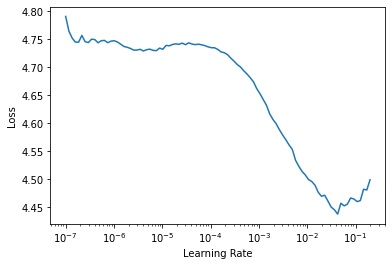

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

32297

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.183577,2.915660,0.359914,03:19
1,2.501913,2.419156,0.508621,03:19
2,2.107378,2.130526,0.610722,03:19
3,1.861023,1.939332,0.675377,03:20
4,1.473328,1.509380,0.814116,03:20


epoch,train_loss,valid_loss,accuracy,time
0,3.119256,2.784009,0.393319,03:20
1,2.496033,2.339811,0.534213,03:20
2,2.103536,2.221379,0.607220,03:20
3,1.821454,1.883924,0.682651,03:20
4,1.475982,1.521100,0.810345,03:19


epoch,train_loss,valid_loss,accuracy,time
0,3.054802,2.806498,0.389547,03:20
1,2.453669,2.441997,0.528556,03:20
2,2.043847,2.110139,0.641433,03:20
3,1.809198,1.920113,0.673222,03:20
4,1.459819,1.479488,0.823006,03:20


In [0]:
print(results)

[0.814116358757019, 0.8103448152542114, 0.8230064511299133]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81582
Accuracy Std: 0.00531


### Exp 1.2: SE reduction=16 - 0.81322

SuggestedLRs(lr_min=0.007854048907756806, lr_steep=0.007766907103359699)

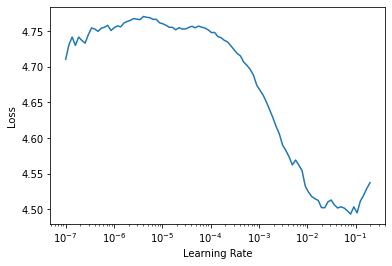

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

17107

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.082099,2.829645,0.414871,03:20
1,2.458935,2.469845,0.500539,03:20
2,2.082224,2.100403,0.642241,03:20
3,1.820228,1.890066,0.675647,03:20
4,1.462617,1.507941,0.817888,03:20


epoch,train_loss,valid_loss,accuracy,time
0,3.174134,2.877535,0.367457,03:20
1,2.489372,2.362944,0.532597,03:20
2,2.114664,2.089768,0.618265,03:20
3,1.874779,1.954901,0.660560,03:20
4,1.501504,1.531363,0.812769,03:20


epoch,train_loss,valid_loss,accuracy,time
0,3.155057,2.830215,0.386315,03:20
1,2.477404,2.366751,0.529364,03:20
2,2.108951,2.045431,0.631465,03:20
3,1.858047,1.998779,0.647090,03:20
4,1.484906,1.521037,0.808998,03:20


In [0]:
print(results)

[0.8178879022598267, 0.8127694129943848, 0.8089978694915771]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81322
Accuracy Std: 0.00364


## Exp 2: ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]]

### Exp 2.1: No SE - 0.82256
Another attempt to replicate Experiment 5.1 from FastGarden MK-ResNeXt-50 D & E with Deconv Stem.

SuggestedLRs(lr_min=0.004944524168968201, lr_steep=0.003078292589634657)

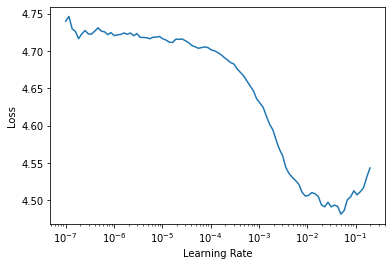

In [0]:
model = mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

31991

In [0]:
results = []
for i in range(3):
    model = mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.130046,2.823358,0.388200,03:29
1,2.470106,2.415440,0.532866,03:29
2,2.075359,2.099607,0.625000,03:29
3,1.855154,1.964465,0.667026,03:29
4,1.453663,1.485790,0.823006,03:29


epoch,train_loss,valid_loss,accuracy,time
0,3.118031,2.792403,0.383082,03:28
1,2.470990,2.382674,0.532058,03:28
2,2.048672,2.011133,0.643588,03:28
3,1.794029,1.779283,0.719828,03:28
4,1.452152,1.479496,0.824623,03:28


epoch,train_loss,valid_loss,accuracy,time
0,3.123114,2.750527,0.411369,03:27
1,2.455721,2.434060,0.509698,03:28
2,2.077757,2.143698,0.601832,03:28
3,1.823730,1.862513,0.701509,03:28
4,1.471359,1.503111,0.820043,03:28


In [0]:
print(results)

[0.8230064511299133, 0.8246228694915771, 0.8200430870056152]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.82256
Accuracy Std: 0.00190


### Exp 2.2: SE reduction=8 - 0.82310

SuggestedLRs(lr_min=0.007854048907756806, lr_steep=0.05769181624054909)

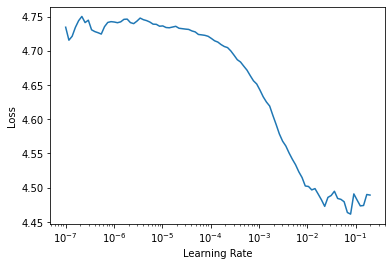

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16075

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.099768,2.749242,0.418103,03:33
1,2.432167,2.291186,0.551455,03:34
2,2.076046,2.113623,0.614224,03:34
3,1.802388,1.787292,0.719289,03:34
4,1.450060,1.482536,0.824084,03:34


epoch,train_loss,valid_loss,accuracy,time
0,3.099313,2.825119,0.400054,03:34
1,2.430867,2.294742,0.549030,03:34
2,2.069170,2.126992,0.611530,03:34
3,1.811457,2.028052,0.646821,03:34
4,1.466327,1.495001,0.822468,03:34


epoch,train_loss,valid_loss,accuracy,time
0,3.165604,2.910845,0.374192,03:34
1,2.483132,2.389787,0.522899,03:34
2,2.080268,2.060769,0.633082,03:34
3,1.841476,1.896657,0.689386,03:34
4,1.469239,1.498483,0.822737,03:34


In [0]:
print(results)

[0.8240840435028076, 0.8224676847457886, 0.8227370977401733]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.82310
Accuracy Std: 0.00071


### Exp 2.3: SE reduction=16 - 0.82399

SuggestedLRs(lr_min=0.004944524168968201, lr_steep=0.004190726205706596)

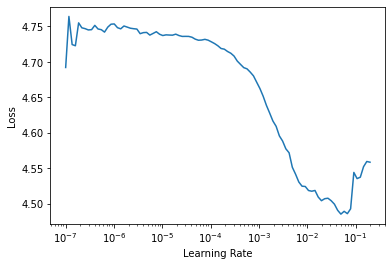

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

17057

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.144420,2.774090,0.396821,03:33
1,2.470971,2.332669,0.543912,03:33
2,2.050507,2.110617,0.623384,03:34
3,1.811149,1.847914,0.703664,03:34
4,1.448799,1.478260,0.822468,03:34


epoch,train_loss,valid_loss,accuracy,time
0,3.144234,2.818263,0.384429,03:33
1,2.466808,2.396341,0.509698,03:33
2,2.076291,2.136000,0.612877,03:33
3,1.830603,2.087988,0.607489,03:34
4,1.441537,1.493276,0.823545,03:34


epoch,train_loss,valid_loss,accuracy,time
0,3.131181,2.831719,0.381196,03:33
1,2.440238,2.323078,0.543642,03:33
2,2.049969,2.046360,0.640356,03:34
3,1.798409,1.845431,0.710668,03:34
4,1.424186,1.478872,0.825970,03:34


In [0]:
print(results)

[0.8224676847457886, 0.8235452771186829, 0.8259698152542114]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.82399
Accuracy Std: 0.00146


## Exp 3: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]]

### Exp 3.1: SE reduction=8 - 0.81133

SuggestedLRs(lr_min=0.004944524168968201, lr_steep=0.002638275967910886)

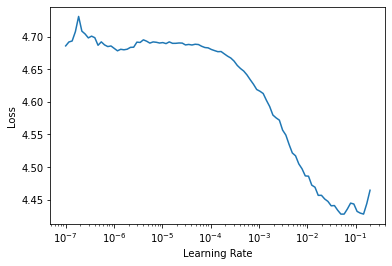

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

32084

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.128816,2.830460,0.379849,03:07
1,2.485813,2.330891,0.542026,03:07
2,2.079154,2.075849,0.620959,03:07
3,1.848979,1.932794,0.672414,03:08
4,1.471900,1.516953,0.809537,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.193083,2.864244,0.373384,03:07
1,2.552919,2.521329,0.470097,03:07
2,2.170386,2.226164,0.585668,03:07
3,1.889887,1.944510,0.672683,03:07
4,1.533838,1.537943,0.802263,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.093566,2.875003,0.377963,03:07
1,2.462278,2.272288,0.552532,03:07
2,2.069067,2.063082,0.617188,03:07
3,1.821255,1.922090,0.689386,03:07
4,1.468378,1.478907,0.822198,03:07


In [0]:
print(results)

[0.8095366358757019, 0.8022629022598267, 0.8221982717514038]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81133
Accuracy Std: 0.00824


### Exp 3.2: SE reduction=16 - 0.81582

SuggestedLRs(lr_min=0.005769181624054908, lr_steep=0.0019379421137273312)

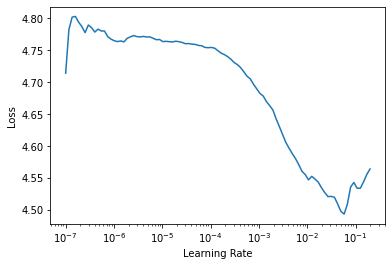

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

17161

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.091251,2.738950,0.406789,03:06
1,2.444034,2.445720,0.521013,03:07
2,2.067947,2.064677,0.636315,03:06
3,1.783252,1.918291,0.671067,03:07
4,1.457693,1.481270,0.821390,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.187587,2.847198,0.371498,03:07
1,2.528827,2.279923,0.547144,03:08
2,2.159891,2.115755,0.606412,03:08
3,1.869149,1.887573,0.682651,03:07
4,1.506388,1.521392,0.807920,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.136842,2.775792,0.398976,03:06
1,2.474600,2.488599,0.517241,03:06
2,2.097620,2.059272,0.622575,03:07
3,1.847140,1.847531,0.706358,03:07
4,1.476963,1.502779,0.818157,03:07


In [0]:
print(results)

[0.8213900923728943, 0.8079202771186829, 0.8181573152542114]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81582
Accuracy Std: 0.00574


## Exp 4: ks=[[3,5], [3,5,7,9], [3,5,7,9], [3]]

### Exp 4.1: SE reduction=8 - 0.82229

SuggestedLRs(lr_min=0.009163962304592132, lr_steep=0.0022611559834331274)

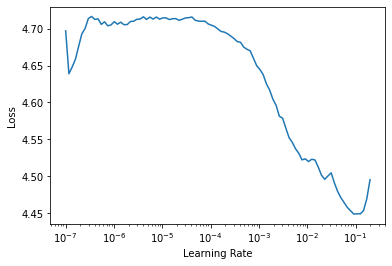

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

15544

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.114043,2.746682,0.401940,03:32
1,2.433071,2.368866,0.529634,03:32
2,2.060254,1.992316,0.654095,03:32
3,1.798365,1.973673,0.662985,03:32
4,1.442315,1.503288,0.820851,03:32


epoch,train_loss,valid_loss,accuracy,time
0,3.117828,2.784689,0.410560,03:32
1,2.441355,2.312835,0.554418,03:32
2,2.058979,2.185949,0.603987,03:32
3,1.799819,1.782679,0.722252,03:32
4,1.438246,1.487714,0.824084,03:32


epoch,train_loss,valid_loss,accuracy,time
0,3.123208,2.878634,0.367726,03:32
1,2.457561,2.352369,0.539062,03:32
2,2.094414,2.039610,0.637662,03:32
3,1.829423,1.909244,0.683459,03:32
4,1.459161,1.493960,0.821929,03:32


In [0]:
print(results)

[0.8208512663841248, 0.8240840435028076, 0.821928858757019]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.82229
Accuracy Std: 0.00134


### Exp 4.2: SE reduction=16 - 0.81941

SuggestedLRs(lr_min=0.005769181624054908, lr_steep=0.003078292589634657)

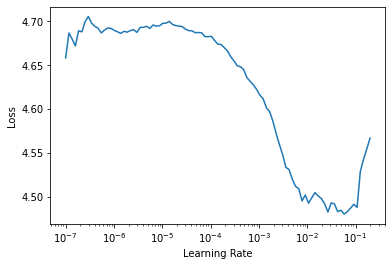

In [0]:
model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

16962

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50f(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5], [3,5,7,9], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.199703,2.898087,0.354795,03:32
1,2.521235,2.284205,0.557920,03:32
2,2.102018,2.089270,0.623114,03:33
3,1.839070,1.883220,0.681843,03:33
4,1.470806,1.500976,0.816541,03:33


epoch,train_loss,valid_loss,accuracy,time
0,3.157907,2.750684,0.411099,03:33
1,2.451702,2.393954,0.523976,03:33
2,2.007791,2.099151,0.619881,03:33
3,1.784384,1.864699,0.702047,03:33
4,1.431857,1.482577,0.819504,03:32


epoch,train_loss,valid_loss,accuracy,time
0,3.193630,2.988375,0.355603,03:32
1,2.478278,2.282968,0.565733,03:32
2,2.066283,2.061968,0.638200,03:32
3,1.812471,1.969996,0.659752,03:33
4,1.455299,1.497379,0.822198,03:33


In [0]:
print(results)

[0.8165409564971924, 0.8195043206214905, 0.8221982717514038]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81941
Accuracy Std: 0.00231


# MK-ResNeXt-50G

## Exp 5: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]]

### Exp 5.1: No SE - 0.82040

SuggestedLRs(lr_min=0.0019596852362155914, lr_steep=0.01679564267396927)

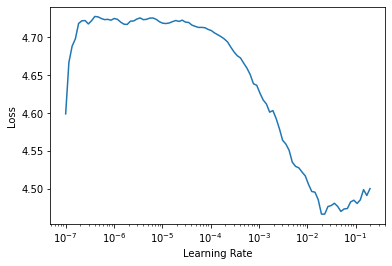

In [0]:
model = mk_resnext50g(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

32456

In [0]:
results = []
for i in range(3):
    model = mk_resnext50g(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.100679,2.804664,0.403825,03:04
1,2.446034,2.399296,0.506735,03:04
2,2.119069,2.036316,0.638739,03:04
3,1.845613,1.865211,0.690194,03:04
4,1.477127,1.500223,0.818427,03:03


epoch,train_loss,valid_loss,accuracy,time
0,3.058518,2.826095,0.390356,03:04
1,2.412131,2.376804,0.535291,03:04
2,2.051127,2.050196,0.642511,03:04
3,1.807836,1.883212,0.693965,03:04
4,1.439548,1.474081,0.828664,03:04


epoch,train_loss,valid_loss,accuracy,time
0,3.157943,2.853574,0.374192,03:04
1,2.519105,2.470428,0.506465,03:04
2,2.131400,2.040004,0.640356,03:04
3,1.858183,1.947329,0.667834,03:04
4,1.499561,1.518473,0.814116,03:04


In [0]:
print(results)

[0.8184267282485962, 0.8286637663841248, 0.814116358757019]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.82040
Accuracy Std: 0.00610


### Exp 5.2: SE reduction=8 - 0.81367

SuggestedLRs(lr_min=0.005769181624054908, lr_steep=0.01679564267396927)

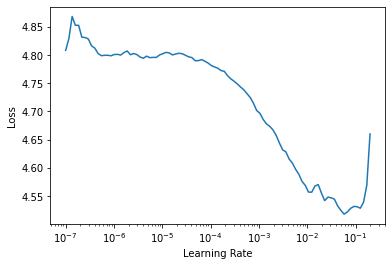

In [0]:
model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

14635

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.134726,2.887934,0.374192,03:08
1,2.517331,2.452238,0.516972,03:08
2,2.093219,2.038328,0.640625,03:08
3,1.829858,1.902315,0.681573,03:08
4,1.493420,1.511562,0.818427,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.134529,2.801821,0.389009,03:08
1,2.484899,2.317900,0.543103,03:08
2,2.136761,2.260655,0.582166,03:08
3,1.832088,1.897123,0.678879,03:08
4,1.492904,1.521608,0.807112,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.135285,2.992875,0.356142,03:08
1,2.525043,2.303075,0.544989,03:08
2,2.096497,2.092746,0.617726,03:08
3,1.848611,1.918547,0.678610,03:08
4,1.462349,1.515845,0.815463,03:08


In [0]:
print(results)

[0.8184267282485962, 0.8071120977401733, 0.8154633641242981]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81367
Accuracy Std: 0.00479


### Exp 5.3: SE reduction=16 - 0.81986

SuggestedLRs(lr_min=0.0031128300353884695, lr_steep=0.004190726205706596)

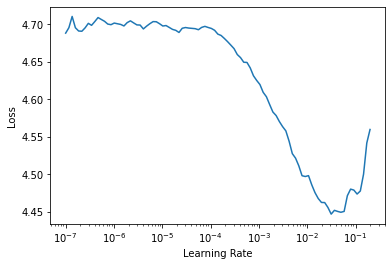

In [0]:
model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

14664

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3,5]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.072432,2.920890,0.391972,03:08
1,2.483360,2.339346,0.551185,03:08
2,2.058218,2.123319,0.634160,03:08
3,1.812764,1.929319,0.679418,03:08
4,1.463991,1.503739,0.816002,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.117783,2.851833,0.385237,03:08
1,2.449553,2.306261,0.556304,03:08
2,2.055768,1.999313,0.647629,03:08
3,1.821387,1.989088,0.663254,03:08
4,1.455323,1.493309,0.821660,03:08


epoch,train_loss,valid_loss,accuracy,time
0,3.079876,2.990036,0.384698,03:08
1,2.466016,2.322827,0.548761,03:08
2,2.080597,1.995986,0.644666,03:08
3,1.820038,1.835884,0.700431,03:08
4,1.457846,1.487701,0.821929,03:08


In [0]:
print(results)

[0.8160021305084229, 0.821659505367279, 0.821928858757019]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81986
Accuracy Std: 0.00273


## Exp 6: ks=[[3,5], [3,5,7,9], [3,5,7,9], [3,5]]
Not ran because this experiment was taking 11 minutes per epoch

## Exp 7: ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]]

### Exp 7.1: Without SE - 0.81825

SuggestedLRs(lr_min=0.004944524168968201, lr_steep=0.03631993755698204)

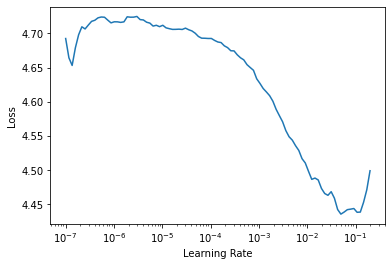

In [0]:
model = mk_resnext50g(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

33086

In [0]:
results = []
for i in range(3):
    model = mk_resnext50g(pretrained=False, n_out=dls.c, sa=True, act_cls=MishCuda, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.114789,3.005446,0.363955,03:02
1,2.489873,2.512146,0.499461,03:02
2,2.089681,2.183547,0.593211,03:03
3,1.842565,1.829541,0.702586,03:03
4,1.491615,1.505007,0.815194,03:03


epoch,train_loss,valid_loss,accuracy,time
0,3.108774,2.748783,0.413254,03:02
1,2.484406,2.553780,0.486261,03:03
2,2.099664,2.112925,0.621228,03:03
3,1.847774,1.884913,0.703394,03:03
4,1.473413,1.502446,0.825162,03:02


epoch,train_loss,valid_loss,accuracy,time
0,3.073207,2.814972,0.396821,03:03
1,2.444121,2.263095,0.567080,03:02
2,2.090034,2.199714,0.595636,03:03
3,1.824521,1.837607,0.715248,03:02
4,1.474019,1.510589,0.814386,03:03


In [0]:
print(results)

[0.8151939511299133, 0.8251616358757019, 0.8143857717514038]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81825
Accuracy Std: 0.00490


### Exp 7.2: SE reduction=8 - 0.81528

SuggestedLRs(lr_min=0.014556346833705902, lr_steep=0.01679564267396927)

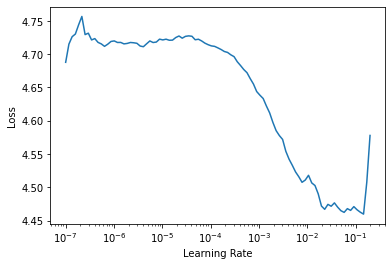

In [0]:
model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8,  ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])
learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

14548

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=8, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])


    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.084463,2.772815,0.415409,03:07
1,2.458772,2.305814,0.555226,03:07
2,2.061534,2.148748,0.607489,03:07
3,1.827759,1.874180,0.698815,03:07
4,1.456353,1.503929,0.824892,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.106541,2.780769,0.408944,03:07
1,2.462399,2.355934,0.550377,03:07
2,2.097964,2.116866,0.619343,03:07
3,1.841511,1.887265,0.687500,03:07
4,1.491819,1.510218,0.811153,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.186419,2.896904,0.362608,03:08
1,2.515280,2.389568,0.517241,03:07
2,2.130399,2.171701,0.598869,03:07
3,1.863215,1.898137,0.689386,03:07
4,1.497311,1.523871,0.809806,03:07


In [0]:
print(results)

[0.8248922228813171, 0.811152994632721, 0.8098060488700867]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81528
Accuracy Std: 0.00682


### Exp 7.3: SE reduction=16 - 0.81160

SuggestedLRs(lr_min=0.005769181624054908, lr_steep=0.0007680731941945851)

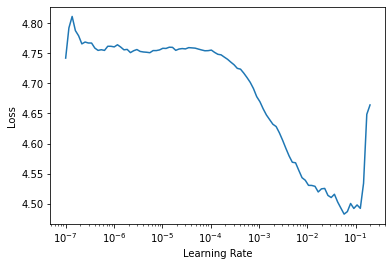

In [0]:
model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

learn = Learner(dls, model, 
                opt_func=ranger,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy])

learn.lr_find(end_lr=5e-1)

In [0]:
learn, model = None, None
gc.collect()

15172

In [0]:
results = []
for i in range(3):
    model = se_mk_resnext50g(pretrained=False, sa=True, n_out=dls.c, act_cls=MishCuda, reduction=16, ks=[[3,5,7,9], [3,5], [3,5,7,9], [3]])

    learn = Learner(dls, model, 
                    opt_func=ranger,
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy])

    learn.fit_flat_cos(5, 8e-3)

    idx = list(learn.recorder.metric_names[1:]).index('accuracy')
    results.append(learn.recorder.values[-1][idx])

    learn, model = None, None
    gc.collect()

epoch,train_loss,valid_loss,accuracy,time
0,3.210708,3.033087,0.339709,03:07
1,2.579635,2.398199,0.515894,03:07
2,2.139779,2.120611,0.616379,03:07
3,1.863487,1.996897,0.667026,03:07
4,1.506182,1.530146,0.804418,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.119139,2.828127,0.387123,03:07
1,2.511967,2.397231,0.520744,03:07
2,2.084436,2.067484,0.621228,03:07
3,1.818195,2.043668,0.639817,03:07
4,1.476828,1.491795,0.820312,03:07


epoch,train_loss,valid_loss,accuracy,time
0,3.174352,2.900259,0.373922,03:07
1,2.540916,2.518476,0.490302,03:08
2,2.134110,2.264486,0.566002,03:08
3,1.838347,1.906060,0.679688,03:08
4,1.497418,1.525318,0.810075,03:08


In [0]:
print(results)

[0.8044180870056152, 0.8203125, 0.8100754022598267]


In [0]:
avgs = np.array(results)

print(f"Average Accuracy: {avgs.mean():.5f}\nAccuracy Std: {avgs.std():.5f}")

Average Accuracy: 0.81160
Accuracy Std: 0.00658
